1. IMPORT LIBRARIES

In [59]:
import pandas as pd
import numpy as np
import warnings


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score, f1_score
)
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    precision_score, recall_score, confusion_matrix
)
from scipy.stats import uniform, randint
import joblib

import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

2. LOAD DATASET

In [2]:
file_path = 'beneficiary_dataset_india.xlsx'

df = pd.read_excel(file_path)

3. DATA EXPLORATION AND VISUALIZATION

In [3]:

# Display dataset overview
print("1. DataFrame Shape:", df.shape)


1. DataFrame Shape: (1000, 23)


In [4]:
print("2. Column Data Types:")
print(df.dtypes)


2. Column Data Types:
beneficiary_id          object
region                  object
household_size         float64
num_loans              float64
avg_loan_amount        float64
on_time_ratio          float64
avg_days_late          float64
max_dpd                float64
num_defaults           float64
avg_kwh_30d            float64
var_kwh_30d            float64
seasonality_index      float64
avg_recharge_amount    float64
recharge_freq_30d      float64
last_recharge_days     float64
bill_on_time_ratio     float64
avg_bill_delay         float64
avg_bill_amount        float64
education_level         object
occupation              object
asset_score            float64
default_flag           float64
income_band             object
dtype: object


In [5]:
print("3. First 5 Rows:")
print(df.head())


3. First 5 Rows:
  beneficiary_id region  household_size  num_loans  avg_loan_amount  \
0          B0001  Rural             8.0        2.0          21977.0   
1          B0002  Urban             2.0        2.0          42402.0   
2          B0003  Urban             2.0        4.0          44542.0   
3          B0004  Rural             3.0        3.0          15651.0   
4          B0005  Rural             7.0        4.0           5935.0   

   on_time_ratio  avg_days_late  max_dpd  num_defaults  avg_kwh_30d  ...  \
0       0.803133       5.553960     29.0           0.0    85.129472  ...   
1       0.834605       8.152903     22.0           0.0   112.245416  ...   
2       0.610975       0.289173     15.0           0.0   124.660880  ...   
3       0.707546       7.272626     13.0           0.0   103.287751  ...   
4       0.743721       2.459670     73.0           0.0    76.413905  ...   

   recharge_freq_30d  last_recharge_days  bill_on_time_ratio  avg_bill_delay  \
0                4.

In [6]:
print("4. Summary Statistics:")
print(df.describe().T)

4. Summary Statistics:
                     count          mean           std          min  \
household_size       956.0      5.441423      2.248378     2.000000   
num_loans            954.0      4.187631      2.588499     1.000000   
avg_loan_amount      956.0  24799.322176  13518.016945  5024.000000   
on_time_ratio        958.0      0.799452      0.131615     0.404638   
avg_days_late        959.0      4.771247      3.210480     0.014103   
max_dpd              960.0     46.701042     27.146403     0.000000   
num_defaults         968.0      0.549587      0.751159     0.000000   
avg_kwh_30d          964.0    110.008248     39.568099     2.223266   
var_kwh_30d          958.0     14.994637      8.446757     0.007503   
seasonality_index    958.0      1.151564      0.203288     0.573255   
avg_recharge_amount  968.0    261.845041    183.130501    50.000000   
recharge_freq_30d    963.0      6.219107      2.915078     2.000000   
last_recharge_days   964.0     15.193983      8.710214

In [7]:
print("5. Missing Values per Column:")
print(df.isnull().sum())

5. Missing Values per Column:
beneficiary_id          0
region                 49
household_size         44
num_loans              46
avg_loan_amount        44
on_time_ratio          42
avg_days_late          41
max_dpd                40
num_defaults           32
avg_kwh_30d            36
var_kwh_30d            42
seasonality_index      42
avg_recharge_amount    32
recharge_freq_30d      37
last_recharge_days     36
bill_on_time_ratio     38
avg_bill_delay         40
avg_bill_amount        42
education_level        36
occupation             41
asset_score            45
default_flag           39
income_band            35
dtype: int64


In [8]:
# Value counts for target variables
print("6. Default Flag Distribution:")
print(df['default_flag'].value_counts())

6. Default Flag Distribution:
default_flag
0.0    653
1.0    308
Name: count, dtype: int64


In [9]:
print("7. Income Band Distribution:")
print(df['income_band'].value_counts())

7. Income Band Distribution:
income_band
Low         329
Very Low    241
Medium      239
High        156
Name: count, dtype: int64


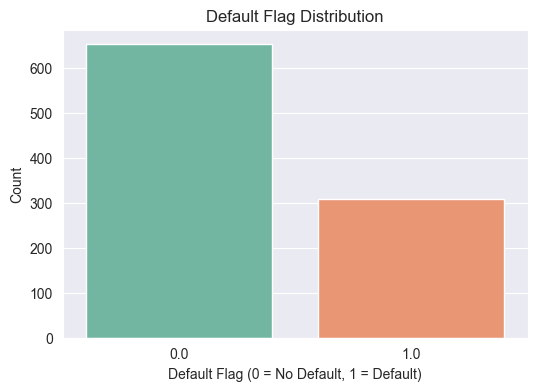

In [10]:
# Visualizations
# a) Default Flag distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x='default_flag', data=df, palette='Set2')
plt.title('Default Flag Distribution')
plt.xlabel('Default Flag (0 = No Default, 1 = Default)')
plt.ylabel('Count')
plt.show()

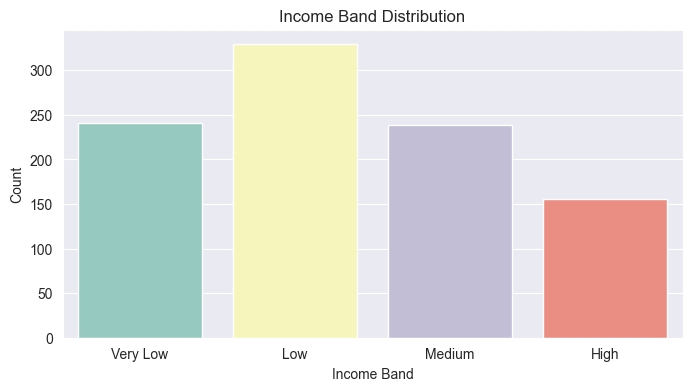

In [11]:
# b) Income Band distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x='income_band', data=df, order=['Very Low','Low','Medium','High'], palette='Set3')
plt.title('Income Band Distribution')
plt.xlabel('Income Band')
plt.ylabel('Count')
plt.show()

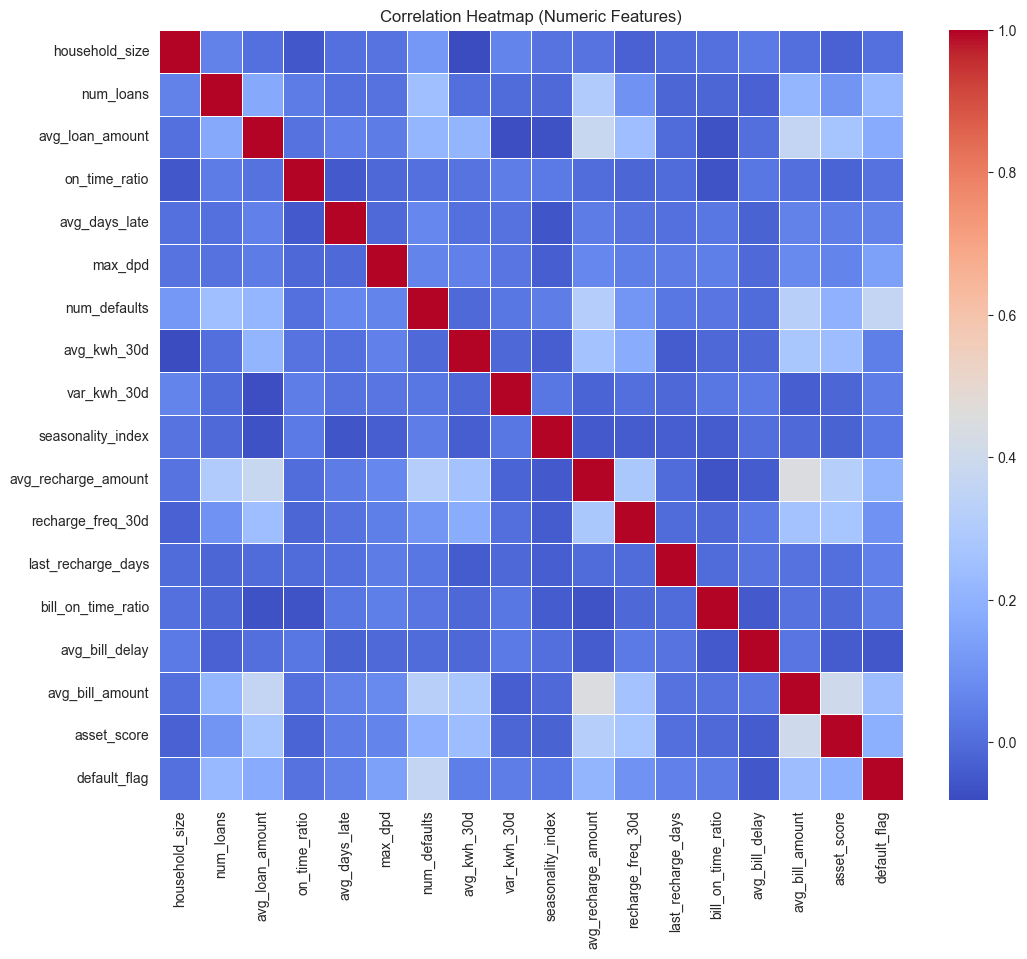

In [12]:
# c) Correlation heatmap of numeric features
plt.figure(figsize=(12,10))
numeric_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Features)')
plt.show()

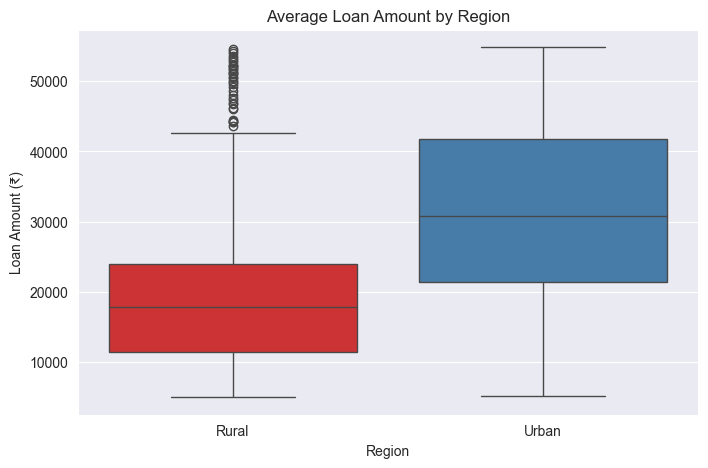

In [13]:
# d) Distribution of avg_loan_amount by region
plt.figure(figsize=(8,5))
sns.boxplot(x='region', y='avg_loan_amount', data=df, palette='Set1')
plt.title('Average Loan Amount by Region')
plt.xlabel('Region')
plt.ylabel('Loan Amount (₹)')
plt.show()

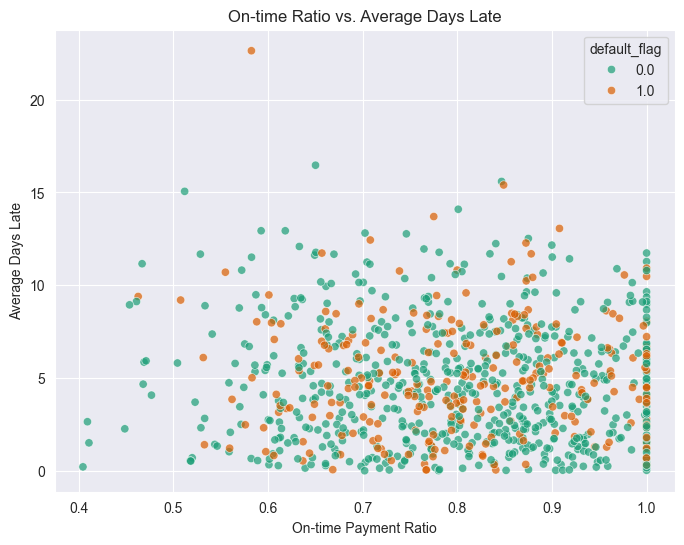

In [14]:
# e) Scatter plot: on_time_ratio vs avg_days_late colored by default_flag
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='on_time_ratio', y='avg_days_late',
    hue='default_flag', data=df, alpha=0.7, palette='Dark2'
)
plt.title('On-time Ratio vs. Average Days Late')
plt.xlabel('On-time Payment Ratio')
plt.ylabel('Average Days Late')
plt.show()

4. DATA PREPROCESSING AND CLEANING

In [15]:
# 4.1 Handle Missing Values (if any)
df_clean = df.copy()
df_clean.fillna(df_clean.median(numeric_only=True), inplace=True)  # Numeric imputation
df_clean.fillna(method='ffill', inplace=True)                     # Forward-fill for categoricals

In [16]:
# 4.2 Encode Categorical Variables

le_region = LabelEncoder()
df_clean['region_encoded'] = le_region.fit_transform(df_clean['region'])

le_edu = LabelEncoder()
df_clean['education_encoded'] = le_edu.fit_transform(df_clean['education_level'])

le_occ = LabelEncoder()
df_clean['occupation_encoded'] = le_occ.fit_transform(df_clean['occupation'])

le_income = LabelEncoder()
df_clean['income_band_encoded'] = le_income.fit_transform(df_clean['income_band'])

In [17]:
# 4.3 Create Derived Features
df_clean['loan_per_household'] = df_clean['avg_loan_amount'] / df_clean['household_size']
df_clean['kwh_per_household']  = df_clean['avg_kwh_30d'] / df_clean['household_size']
df_clean['recharge_intensity'] = df_clean['avg_recharge_amount'] / df_clean['recharge_freq_30d']
df_clean['payment_reliability'] = (df_clean['on_time_ratio'] + df_clean['bill_on_time_ratio']) / 2
df_clean['financial_stability'] = df_clean['asset_score'] / (df_clean['num_defaults'] + 1)

In [18]:
# 4.4 Remove or Cap Outliers (Example: cap avg_loan_amount at 99th percentile)
cap_value = df_clean['avg_loan_amount'].quantile(0.99)
df_clean['avg_loan_amount'] = df_clean['avg_loan_amount'].clip(upper=cap_value)

In [19]:
# 4.5 Normalize or Scale Features (fit later on training data)
numeric_features = [
    'household_size', 'num_loans', 'avg_loan_amount', 'on_time_ratio',
    'avg_days_late', 'max_dpd', 'num_defaults', 'avg_kwh_30d', 'var_kwh_30d',
    'seasonality_index', 'avg_recharge_amount', 'recharge_freq_30d',
    'last_recharge_days', 'bill_on_time_ratio', 'avg_bill_delay',
    'avg_bill_amount', 'asset_score', 'loan_per_household',
    'kwh_per_household', 'recharge_intensity', 'payment_reliability',
    'financial_stability'
]

In [20]:
# Save preprocessed DataFrame for next steps
df_clean.to_csv('beneficiary_dataset_preprocessed.csv', index=False)

5. Basic Data Exploration & Visualization After Preprocessing

In [21]:
# Load preprocessed data
df_pre = pd.read_csv('beneficiary_dataset_preprocessed.csv')

5.1 Display basic info


In [22]:
df_pre.shape

(1000, 32)

In [23]:
df_pre.dtypes

beneficiary_id          object
region                  object
household_size         float64
num_loans              float64
avg_loan_amount        float64
on_time_ratio          float64
avg_days_late          float64
max_dpd                float64
num_defaults           float64
avg_kwh_30d            float64
var_kwh_30d            float64
seasonality_index      float64
avg_recharge_amount    float64
recharge_freq_30d      float64
last_recharge_days     float64
bill_on_time_ratio     float64
avg_bill_delay         float64
avg_bill_amount        float64
education_level         object
occupation              object
asset_score            float64
default_flag           float64
income_band             object
region_encoded           int64
education_encoded        int64
occupation_encoded       int64
income_band_encoded      int64
loan_per_household     float64
kwh_per_household      float64
recharge_intensity     float64
payment_reliability    float64
financial_stability    float64
dtype: o

In [24]:
df_pre.head()

,beneficiary_id,region,household_size,num_loans,avg_loan_amount,on_time_ratio,avg_days_late,max_dpd,num_defaults,avg_kwh_30d,...,income_band,region_encoded,education_encoded,occupation_encoded,income_band_encoded,loan_per_household,kwh_per_household,recharge_intensity,payment_reliability,financial_stability
0,B0001,Rural,8.0,2.0,21977.0,0.803133,5.553960,29.0,0.0,85.129472,...,Low,0,3,3,1,2747.125000,10.641184,13.500000,0.769544,0.0
1,B0002,Urban,2.0,2.0,42402.0,0.834605,8.152903,22.0,0.0,112.245416,...,Medium,1,2,1,2,21201.000000,56.122708,61.166667,0.540075,5.0
2,B0003,Urban,2.0,4.0,44542.0,0.610975,0.289173,15.0,0.0,124.660880,...,Medium,1,3,1,2,22271.000000,62.330440,32.285714,0.665291,2.0
3,B0004,Rural,3.0,3.0,15651.0,0.707546,7.272626,13.0,0.0,103.287751,...,Very Low,0,1,1,3,5217.000000,34.429250,10.857143,0.834787,1.0
4,B0005,Rural,7.0,4.0,5935.0,0.743721,2.459670,73.0,0.0,76.413905,...,Low,0,3,3,1,847.857143,10.916272,63.500000,0.657486,2.0


In [25]:
df_pre.describe().T

,count,mean,std,min,25%,50%,75%,max
household_size,1000.0,5.422000,2.200172,2.000000,4.000000,5.000000,7.000000,10.000000
num_loans,1000.0,4.179000,2.528508,1.000000,2.000000,4.000000,6.000000,10.000000
avg_loan_amount,1000.0,24662.180700,13219.872626,5024.000000,14335.500000,21798.500000,34092.500000,53925.870000
on_time_ratio,1000.0,0.799677,0.128823,0.404638,0.709089,0.804796,0.895114,1.000000
avg_days_late,1000.0,4.754966,3.144896,0.014103,2.300895,4.374139,6.660130,22.631189
max_dpd,1000.0,46.673000,26.597735,0.000000,25.000000,46.000000,69.000000,98.000000
num_defaults,1000.0,0.532000,0.745340,0.000000,0.000000,0.000000,1.000000,2.000000
avg_kwh_30d,1000.0,109.775101,38.867368,2.223266,83.544275,103.531938,133.314464,245.207606
var_kwh_30d,1000.0,14.979216,8.267620,0.007503,8.566804,14.627462,20.450396,42.661399
seasonality_index,1000.0,1.151750,0.198970,0.573255,0.999300,1.155997,1.303699,1.740332


5.2 Re-check target distributions

In [26]:
print("Default Flag Distribution:\n", df_pre['default_flag'].value_counts())

Default Flag Distribution:
 default_flag
0.0    692
1.0    308
Name: count, dtype: int64


In [27]:
print("Income Band Distribution:\n", df_pre['income_band'].value_counts())

Income Band Distribution:
 income_band
Low         335
Very Low    253
Medium      248
High        164
Name: count, dtype: int64


5.3 Visualizations

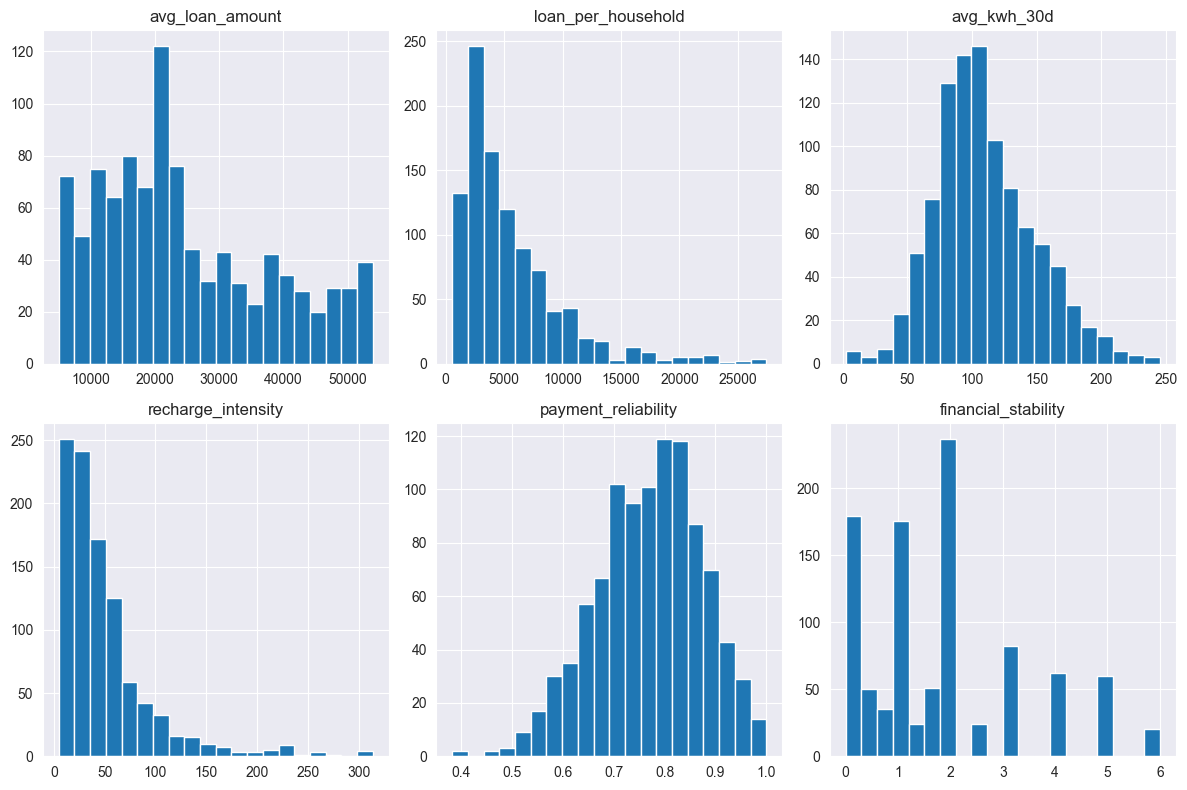

In [28]:
# a) Histogram of composite numeric feature distributions
numeric_feats = [
    'avg_loan_amount', 'loan_per_household', 'avg_kwh_30d',
    'recharge_intensity', 'payment_reliability', 'financial_stability'
]
df_pre[numeric_feats].hist(bins=20, figsize=(12, 8), layout=(2, 3))
plt.tight_layout()
plt.show()

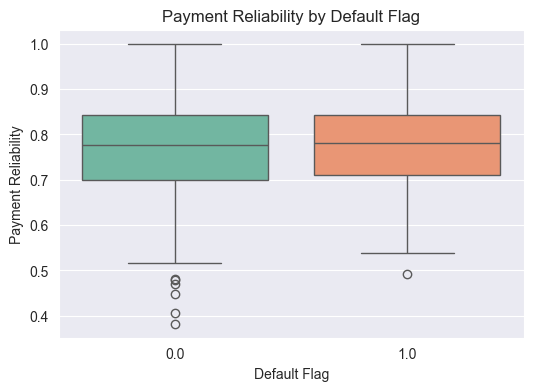

In [29]:
# b) Boxplot: payment_reliability by default_flag
plt.figure(figsize=(6, 4))
sns.boxplot(x='default_flag', y='payment_reliability', data=df_pre, palette='Set2')
plt.title('Payment Reliability by Default Flag')
plt.xlabel('Default Flag')
plt.ylabel('Payment Reliability')
plt.show()

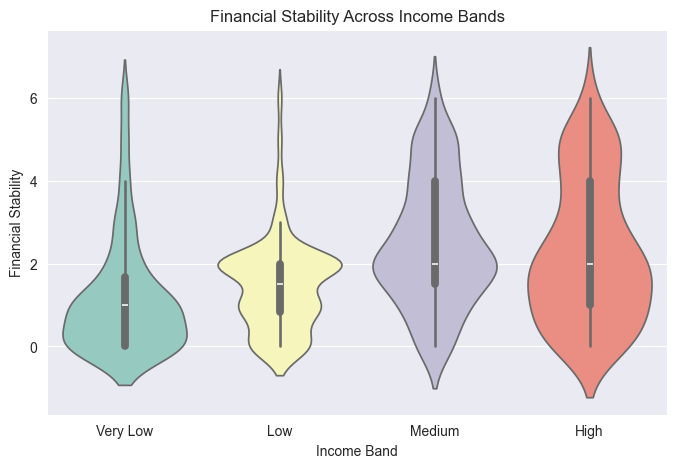

In [30]:
# c) Violin plot: financial_stability vs income_band
plt.figure(figsize=(8, 5))
sns.violinplot(x='income_band', y='financial_stability', data=df_pre,
               order=['Very Low','Low','Medium','High'], palette='Set3')
plt.title('Financial Stability Across Income Bands')
plt.xlabel('Income Band')
plt.ylabel('Financial Stability')
plt.show()

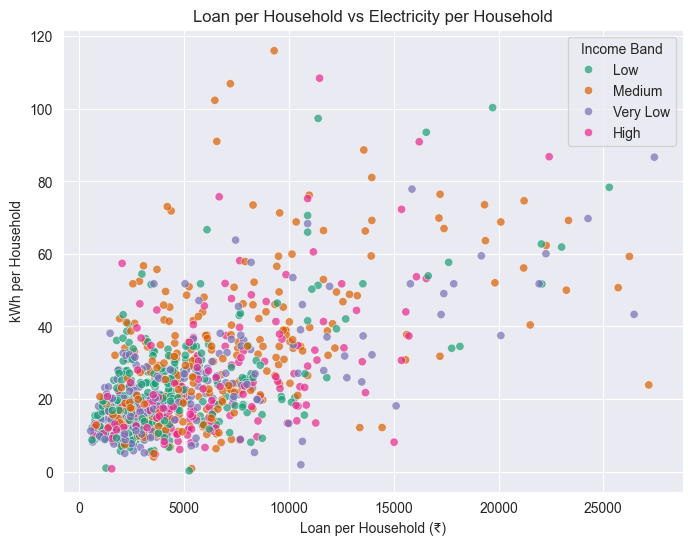

In [31]:
# d) Scatter: loan_per_household vs kwh_per_household colored by income_band
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='loan_per_household',
    y='kwh_per_household',
    hue='income_band',
    data=df_pre,
    palette='Dark2',
    alpha=0.7
)
plt.title('Loan per Household vs Electricity per Household')
plt.xlabel('Loan per Household (₹)')
plt.ylabel('kWh per Household')
plt.legend(title='Income Band')
plt.show()

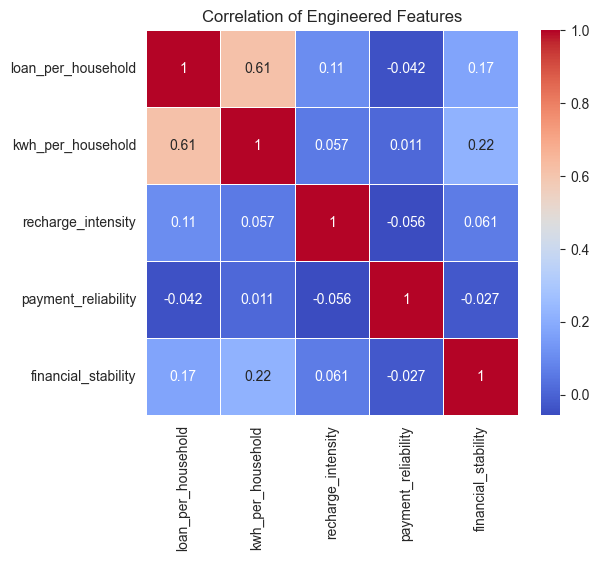

In [32]:
# e) Correlation heatmap of engineered features
eng_feats = ['loan_per_household', 'kwh_per_household',
             'recharge_intensity', 'payment_reliability', 'financial_stability']
plt.figure(figsize=(6, 5))
sns.heatmap(df_pre[eng_feats].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation of Engineered Features')
plt.show()

6: Selecting and Initializing the ML Model for RISK PREDICTION

In [33]:
# For default risk prediction (binary classification), we'll compare:
#   1. Logistic Regression
#   2. Random Forest
#   3. Gradient Boosting

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Initialize models with balanced class weights and consistent random state
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, class_weight='balanced', max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, random_state=42, class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, random_state=42
    )
}

# Display initialized models
for name, model in models.items():
    print(f"{name}: {model}")

Logistic Regression: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
Random Forest: RandomForestClassifier(class_weight='balanced', random_state=42)
Gradient Boosting: GradientBoostingClassifier(random_state=42)


6.1 TRAINING AND EVALUATING

In [34]:
features_default = [
    'region_encoded', 'household_size', 'num_loans', 'avg_loan_amount',
    'on_time_ratio', 'avg_days_late', 'max_dpd', 'avg_kwh_30d',
    'var_kwh_30d', 'seasonality_index', 'avg_recharge_amount',
    'recharge_freq_30d', 'last_recharge_days', 'bill_on_time_ratio',
    'avg_bill_delay', 'avg_bill_amount', 'education_encoded',
    'occupation_encoded', 'asset_score', 'loan_per_household',
    'payment_reliability', 'financial_stability'
]

# Prepare data
X = df_clean[features_default]
y = df_clean['default_flag']

In [35]:
# Splitting into 80% train, 10% validation, 10% test

# First split off 20% for temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Then split temp into equal validation and test sets (10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,    # half of 20% = 10% of total
    random_state=42,
    stratify=y_temp
)

In [36]:
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.0%})")

Training set: 800 samples (80%)


In [37]:
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.0%})")
print(f"Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.0%})")

Validation set: 100 samples (10%)
Testing set: 100 samples (10%)


In [38]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [39]:
X_train_scaled

array([[-0.81649658,  0.72468489, -0.44232621, ..., -0.84600825,
        -0.94461933,  0.15974613],
       [ 1.22474487, -1.53818752,  1.56596532, ..., -0.30308978,
         1.0593757 ,  0.49783318],
       [-0.81649658, -1.08561304,  0.3609904 , ...,  1.11003999,
         1.02205236,  2.8644425 ],
       ...,
       [ 1.22474487, -0.63303856,  1.56596532, ..., -0.026655  ,
         0.99946852,  2.1882684 ],
       [-0.81649658,  0.27211041,  0.3609904 , ..., -0.46582819,
         0.42481176, -1.19260205],
       [-0.81649658, -0.18046407, -0.0406679 , ..., -1.00905056,
        -2.33994705,  0.15974613]], shape=(800, 22))

In [40]:
X_val_scaled

array([[ 1.22474487, -1.53818752, -0.44232621, ...,  0.2014697 ,
        -1.53039526,  0.83592022],
       [ 1.22474487, -0.63303856,  2.36928193, ...,  0.21470077,
        -0.4689613 ,  2.1882684 ],
       [-0.81649658, -1.08561304, -0.0406679 , ..., -0.71977572,
         0.06668675,  0.15974613],
       ...,
       [ 1.22474487,  0.27211041, -0.44232621, ...,  0.36591296,
        -0.37087676, -0.17834092],
       [-0.81649658,  1.17725937, -0.0406679 , ..., -0.55589766,
        -0.35523307,  0.15974613],
       [ 1.22474487,  0.27211041,  0.76264871, ..., -0.7812242 ,
         0.19808615, -0.96721069]], shape=(100, 22))

In [41]:
X_test_scaled

array([[-0.81649658, -0.63303856, -1.24564282, ..., -0.45457993,
         0.96762288, -0.51642796],
       [ 1.22474487,  2.08240833, -0.84398451, ..., -0.19833087,
        -0.22052559, -0.2910366 ],
       [ 1.22474487, -1.53818752, -0.0406679 , ...,  3.95097601,
        -0.05492951,  1.51209431],
       ...,
       [ 1.22474487, -0.18046407,  0.3609904 , ...,  0.50569528,
         0.11909494,  1.51209431],
       [-0.81649658, -1.08561304,  1.16430701, ...,  2.17956972,
        -0.27655525, -1.19260205],
       [-0.81649658,  0.72468489,  0.76264871, ..., -1.00900609,
        -0.06374565, -0.85451501]], shape=(100, 22))

In [42]:
# Optionally, convert back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_default, index=X_train.index)
X_val_scaled   = pd.DataFrame(X_val_scaled,   columns=features_default, index=X_val.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=features_default, index=X_test.index)


In [43]:
X_train_scaled

,region_encoded,household_size,num_loans,avg_loan_amount,on_time_ratio,avg_days_late,max_dpd,avg_kwh_30d,var_kwh_30d,seasonality_index,...,last_recharge_days,bill_on_time_ratio,avg_bill_delay,avg_bill_amount,education_encoded,occupation_encoded,asset_score,loan_per_household,payment_reliability,financial_stability
297,-0.816497,0.724685,-0.442326,-0.929993,-0.832172,0.093954,1.355402,-0.030093,-1.202885,0.823996,...,-0.848612,-0.524109,1.156724,-1.109993,1.248832,-0.248041,-0.206714,-0.846008,-0.944619,0.159746
829,1.224745,-1.538188,1.565965,-1.233595,1.097388,0.714490,0.866986,0.908697,-0.308732,0.415495,...,1.598887,0.463925,-0.259435,0.166608,0.291873,0.618479,1.452528,-0.303090,1.059376,0.497833
650,-0.816497,-1.085613,0.360990,0.558672,0.019091,-0.007192,-0.034706,0.161729,-0.794920,-0.435162,...,0.083769,1.232155,-0.542305,-0.962341,1.248832,1.484999,2.005609,1.110040,1.022052,2.864442
682,1.224745,-0.180464,2.369282,0.628757,1.246065,-0.872246,1.129979,-1.326296,1.757957,-0.602585,...,1.016149,-1.069679,2.046694,-0.587331,-1.622047,-0.248041,0.899447,0.211098,-0.106029,0.159746
119,-0.816497,-1.085613,-0.040668,-0.067324,-0.592630,-1.270741,1.017268,-0.060030,0.660777,-0.052082,...,-1.431350,1.183611,-0.097323,-0.849969,-0.665087,-1.114562,-0.759795,0.507563,0.603751,-0.516428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
928,-0.816497,0.724685,-0.442326,-0.202682,0.019091,-0.017966,1.806248,0.499397,-0.803596,-1.221475,...,-1.431350,-0.551924,-0.127873,-0.894395,1.248832,-1.114562,-0.206714,-0.546014,-0.440709,-0.741819
303,-0.816497,0.272110,-0.843985,-1.299676,1.552349,2.127173,-0.109847,-1.234601,1.028972,0.528172,...,1.249244,1.522759,-0.001318,-0.676184,1.248832,1.484999,-1.312875,-0.958491,2.209016,-1.192602
532,1.224745,-0.633039,1.565965,-0.202682,0.019091,1.912636,0.228288,-0.195020,-0.022826,-1.078556,...,0.666506,1.204610,-0.752363,-0.221468,-1.622047,-0.248041,1.452528,-0.026655,0.999469,2.188268
136,-0.816497,0.272110,0.360990,-0.275887,-0.722563,-1.274908,-1.424814,-0.676757,2.345025,-0.419152,...,1.016149,1.063420,-0.715444,-0.818609,0.291873,1.484999,-1.312875,-0.465828,0.424812,-1.192602


In [44]:
X_val_scaled

,region_encoded,household_size,num_loans,avg_loan_amount,on_time_ratio,avg_days_late,max_dpd,avg_kwh_30d,var_kwh_30d,seasonality_index,...,last_recharge_days,bill_on_time_ratio,avg_bill_delay,avg_bill_amount,education_encoded,occupation_encoded,asset_score,loan_per_household,payment_reliability,financial_stability
304,1.224745,-1.538188,-0.442326,-0.884091,-0.701996,0.868584,-0.184988,2.429553,-0.341112,0.804276,...,-1.664445,-1.336799,-1.034246,0.414872,-1.622047,-1.114562,0.346367,0.201470,-1.530395,0.835920
920,1.224745,-0.633039,2.369282,0.131688,-0.794872,-0.900642,-0.222558,-0.192790,-1.310591,0.486171,...,0.083769,0.027885,-1.362507,-0.839515,-1.622047,-1.114562,1.452528,0.214701,-0.468961,2.188268
38,-0.816497,-1.085613,-0.040668,-1.342575,-1.901484,-0.853711,-1.312102,0.287538,0.243733,0.366839,...,-0.265874,1.516316,0.166826,-0.761116,1.248832,-1.114562,-0.206714,-0.719776,0.066687,0.159746
307,-0.816497,-1.085613,0.360990,-1.058535,0.537532,-0.715356,0.453711,-1.009667,1.061381,-0.195313,...,-0.965159,0.194010,-0.585832,-1.059033,1.248832,1.484999,-0.206714,-0.446408,0.491665,0.159746
825,1.224745,0.724685,0.762649,1.071606,0.247228,-0.742760,-1.086679,-0.195020,-0.621736,1.059370,...,0.083769,-0.999173,-0.663389,0.058156,1.248832,-0.248041,-1.312875,-0.020409,-0.666248,-1.192602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1.224745,0.272110,-0.442326,-0.307849,-1.822524,-0.429016,-0.710974,-0.412680,-0.588598,-1.017622,...,0.549959,-0.411408,-0.050120,0.265914,-0.665087,1.484999,1.452528,-0.481209,-1.464993,2.188268
449,-0.816497,-1.085613,-0.040668,-1.330252,0.711563,0.750262,-0.635833,-1.063422,0.736549,0.004143,...,0.783054,-0.813870,-0.647585,-1.211912,1.248832,-1.114562,-1.312875,-0.707916,-0.227013,-1.192602
390,1.224745,0.272110,-0.442326,1.452533,-0.274268,-1.476256,-0.673404,0.646713,0.098911,0.146166,...,-0.615517,-0.245366,-0.778302,-0.161362,0.291873,-0.248041,0.346367,0.365913,-0.370877,-0.178341
439,-0.816497,1.177259,-0.040668,0.009770,-0.557370,0.602284,-0.184988,-0.684164,0.681899,0.833088,...,-0.265874,-0.012638,-1.047995,-1.158339,1.248832,0.618479,-0.206714,-0.555898,-0.355233,0.159746


In [45]:
X_test_scaled

,region_encoded,household_size,num_loans,avg_loan_amount,on_time_ratio,avg_days_late,max_dpd,avg_kwh_30d,var_kwh_30d,seasonality_index,...,last_recharge_days,bill_on_time_ratio,avg_bill_delay,avg_bill_amount,education_encoded,occupation_encoded,asset_score,loan_per_household,payment_reliability,financial_stability
283,-0.816497,-0.633039,-1.245643,-0.795521,-0.453954,1.703060,1.242691,-0.349180,-0.407192,0.411155,...,1.132696,1.522759,-0.718741,-0.928368,1.248832,-0.248041,-0.759795,-0.454580,0.967623,-0.516428
728,1.224745,2.082408,-0.843985,1.721015,0.023094,-0.221516,-0.034706,-0.195020,-1.197498,0.156772,...,1.598887,-0.286395,0.344893,1.779019,-1.622047,0.618479,0.899447,-0.198331,-0.220526,-0.291037
242,1.224745,-1.538188,-0.040668,1.713159,-0.116885,0.214066,-1.161820,0.711817,-1.064744,-0.917676,...,0.433411,0.021214,-0.870542,-0.324694,0.291873,-0.248041,0.899447,3.950976,-0.054930,1.512094
456,-0.816497,-1.085613,1.565965,-0.326333,1.038341,0.125034,1.580825,0.085627,-0.636611,0.072133,...,-0.848612,1.522759,-0.396433,-0.953194,0.291873,1.484999,-1.312875,0.258285,1.890975,-1.192602
487,-0.816497,0.724685,-1.245643,-0.336268,0.450257,-0.983904,0.979697,0.241070,-0.291624,1.674429,...,-0.498969,-1.645229,2.236080,-0.938821,0.291873,-1.114562,-1.312875,-0.601114,-1.070324,-1.192602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,1.224745,-0.633039,-0.843985,-0.935616,-0.332748,-0.052569,-1.086679,3.005399,-1.421978,-0.404722,...,-0.732064,0.564556,-1.156571,-0.228001,-0.665087,-0.248041,0.346367,-0.555703,0.256992,0.835920
730,1.224745,2.082408,1.565965,2.252356,-0.111369,-0.321167,0.679133,-2.665573,0.886305,0.479374,...,0.083769,0.174229,-0.887477,-0.284841,-1.622047,0.618479,0.899447,-0.044917,0.073941,0.159746
271,1.224745,-0.180464,0.360990,1.138919,-0.069804,-0.669781,1.017268,1.438114,-0.159400,-0.658535,...,-0.032779,0.197934,-1.169418,1.129612,1.248832,-0.248041,0.899447,0.505695,0.119095,1.512094
948,-0.816497,-1.085613,1.164307,1.669952,-0.065913,-0.821401,0.829415,-0.494025,-1.031994,0.643027,...,-1.198254,-0.287563,3.158172,-0.101256,-0.665087,-0.248041,-1.312875,2.179570,-0.276555,-1.192602


In [46]:
# Save scaler for later use
joblib.dump(scaler, 'default_feature_scaler.pkl')

['default_feature_scaler.pkl']

In [47]:
print("Scaled feature means (train):")
print(X_train_scaled.mean().round(2))

print("\nScaled feature std devs (train):")
print(X_train_scaled.std().round(2))

Scaled feature means (train):
region_encoded        -0.0
household_size         0.0
num_loans             -0.0
avg_loan_amount       -0.0
on_time_ratio          0.0
avg_days_late          0.0
max_dpd                0.0
avg_kwh_30d            0.0
var_kwh_30d           -0.0
seasonality_index      0.0
avg_recharge_amount    0.0
recharge_freq_30d     -0.0
last_recharge_days     0.0
bill_on_time_ratio     0.0
avg_bill_delay        -0.0
avg_bill_amount       -0.0
education_encoded     -0.0
occupation_encoded     0.0
asset_score            0.0
loan_per_household    -0.0
payment_reliability    0.0
financial_stability    0.0
dtype: float64

Scaled feature std devs (train):
region_encoded         1.0
household_size         1.0
num_loans              1.0
avg_loan_amount        1.0
on_time_ratio          1.0
avg_days_late          1.0
max_dpd                1.0
avg_kwh_30d            1.0
var_kwh_30d            1.0
seasonality_index      1.0
avg_recharge_amount    1.0
recharge_freq_30d      1.0
las

In [63]:
# PyTorch logistic regression model
class TorchLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(TorchLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_logistic_regression(X_train, y_train, X_val, y_val, params):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TorchLogisticRegression(X_train.shape[1]).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params.get('lr', 0.01))

    # Convert DataFrame to numpy arrays first, then to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1,1), dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val.values.reshape(-1,1), dtype=torch.float32).to(device)

    epochs = params.get('epochs', 100)
    batch_size = params.get('batch_size', 64)
    n_samples = X_train_tensor.size(0)

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(n_samples)
        for i in range(0, n_samples, batch_size):
            indices = permutation[i:i+batch_size]
            batch_x = X_train_tensor[indices]
            batch_y = y_train_tensor[indices]
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).cpu().numpy()
    val_auc = roc_auc_score(y_val, val_outputs)
    return model, val_auc

def random_search_torch(X_train, y_train, X_val, y_val, param_dist, n_iter=20):
    best_auc = 0
    best_params = None
    best_model = None
    for _ in range(n_iter):
        params = {
            'lr': param_dist['lr'].rvs(),
            'epochs': np.random.choice(param_dist['epochs']),
            'batch_size': np.random.choice(param_dist['batch_size'])
        }
        model, val_auc = train_logistic_regression(X_train, y_train, X_val, y_val, params)
        if val_auc > best_auc:
            best_auc = val_auc
            best_params = params
            best_model = model
    print(f"TorchLogistic Best params: {best_params}, Validation AUC: {best_auc:.4f}")
    return best_model, best_params

param_distributions = {
    'TorchLogistic': {
        'lr': uniform(1e-4, 1e-1),
        'epochs': [50, 100, 200],
        'batch_size': [32, 64, 128]
    },
    'RandomForest': {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['sqrt', 'log2', 0.3, 0.5],
        'bootstrap': [True, False]
    },
    'GradientBoosting': {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.001, 0.3),
        'max_depth': randint(2, 15),
        'subsample': uniform(0.5, 1.0)
    }
}

In [64]:
def two_step_tuning_sklearn(model, param_dist, X_train, y_train, model_name):
    print(f"\n🔍 Tuning {model_name}...")
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=50,
        scoring='roc_auc',
        cv=5,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    random_search.fit(X_train, y_train)
    print(f"  Best random search score: {random_search.best_score_:.4f}")
    print(f"  Best random params: {random_search.best_params_}")
    best_params = random_search.best_params_

    if model_name == 'RandomForest':
        refined_grid = {
            'n_estimators': [max(50, best_params['n_estimators'] - 50), best_params['n_estimators'], best_params['n_estimators'] + 50],
            'max_depth': [max(3, best_params['max_depth'] - 2), best_params['max_depth'], best_params['max_depth'] + 2],
            'min_samples_split': [max(2, best_params['min_samples_split'] - 2), best_params['min_samples_split'], best_params['min_samples_split'] + 2],
            'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1), best_params['min_samples_leaf'], best_params['min_samples_leaf'] + 1],
            'max_features': [best_params['max_features']],
            'bootstrap': [best_params['bootstrap']]
        }
    else:  # GradientBoosting = xgboost here
        refined_grid = {
            'n_estimators': [max(50, best_params['n_estimators'] - 50), best_params['n_estimators'], best_params['n_estimators'] + 50],
            'learning_rate': [best_params['learning_rate'] * 0.5, best_params['learning_rate'], best_params['learning_rate'] * 1.5],
            'max_depth': [max(2, best_params['max_depth'] - 1), best_params['max_depth'], best_params['max_depth'] + 1],
            'subsample': [max(0.5, best_params['subsample'] - 0.1), best_params['subsample'], min(1.0, best_params['subsample'] + 0.1)]
        }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=refined_grid,
        scoring='roc_auc',
        cv=5,
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    print(f"  Best grid search score: {grid_search.best_score_:.4f}")
    print(f"  Final best params: {grid_search.best_params_}")
    return grid_search.best_estimator_


In [ ]:
# Tune PyTorch logistic regression manually
torch_logistic_model, _ = random_search_torch(
    X_train_scaled, y_train, X_val_scaled, y_val, param_distributions['TorchLogistic'], n_iter=20
)

# Tune RandomForest
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
tuned_rf = two_step_tuning_sklearn(base_rf, param_distributions['RandomForest'], X_train, y_train, 'RandomForest')

# Tune XGBoost GPU
base_xgb = xgb.XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
tuned_xgb = two_step_tuning_sklearn(base_xgb, param_distributions['GradientBoosting'], X_train, y_train, 'GradientBoosting')

print("\n✅ Individual model tuning completed!")
# Wrapper for PyTorch logistic regression for ensemble compatibility
class TorchLogisticForEnsemble:
    def __init__(self, model):
        self.model = model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)
    def predict_proba(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X.values, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_tensor).cpu().numpy()
        probs = np.hstack((1 - probs, probs))
        return probs

ensemble_lr = TorchLogisticForEnsemble(torch_logistic_model)


TorchLogistic Best params: {'lr': np.float64(0.050775009917301855), 'epochs': np.int64(100), 'batch_size': np.int64(32)}, Validation AUC: 0.6802

🔍 Tuning RandomForest...


In [55]:
    # EVALUATE TUNED BASE MODELS
    # ============================================================================

    print("\n📊 Evaluating Tuned Base Models on Validation Set...")
    print("=" * 60)

    def evaluate_model(model, X_val, y_val, model_name, use_scaled=False):
        """Evaluate model and return metrics"""
        X_input = X_val_scaled if use_scaled else X_val

        y_pred = model.predict(X_input)
        y_proba = model.predict_proba(X_input)[:, 1]

        metrics = {
            'accuracy': accuracy_score(y_val, y_pred),
            'auc': roc_auc_score(y_val, y_proba),
            'f1': f1_score(y_val, y_pred),
            'precision': precision_score(y_val, y_pred),
            'recall': recall_score(y_val, y_pred)
        }

        print(f"{model_name:20} | AUC: {metrics['auc']:.4f} | Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")

        return {
            'model': model,
            'metrics': metrics,
            'predictions': y_pred,
            'probabilities': y_proba
        }

    # Evaluate tuned models
    tuned_results = {}
    tuned_results['Logistic Regression'] = evaluate_model(
        tuned_models['LogisticRegression'], X_val, y_val, 'Logistic Regression', use_scaled=True
    )
    tuned_results['Random Forest'] = evaluate_model(
        tuned_models['RandomForest'], X_val, y_val, 'Random Forest', use_scaled=False
    )
    tuned_results['Gradient Boosting'] = evaluate_model(
        tuned_models['GradientBoosting'], X_val, y_val, 'Gradient Boosting', use_scaled=False
    )


📊 Evaluating Tuned Base Models on Validation Set...
Logistic Regression  | AUC: 0.6704 | Acc: 0.6400 | F1: 0.5000
Random Forest        | AUC: 0.7158 | Acc: 0.6700 | F1: 0.4762
Gradient Boosting    | AUC: 0.6727 | Acc: 0.6500 | F1: 0.4068


In [56]:
# Voting ensemble (using sklearn LogisticRegression for compatibility)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
        ('rf', tuned_rf),
        ('xgb', tuned_xgb)
    ],
    voting='soft'
)
voting_clf.fit(X_train_scaled, y_train)

# Stacking ensemble with only sklearn-compatible models
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', tuned_rf),
        ('xgb', tuned_xgb)
    ],
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    passthrough=True
)
stacking_clf.fit(X_train_scaled, y_train)



🤖 Building and Tuning Ensemble Models...
Building Voting Classifier...
Voting Ensemble      | AUC: 0.7144 | Acc: 0.6900 | F1: 0.4918
Building Stacking Classifier...
Stacking Ensemble    | AUC: 0.7101 | Acc: 0.6700 | F1: 0.5352


In [57]:
# MODEL SELECTION AND FINAL EVALUATION
# ============================================================================

print("\n🏆 Final Model Selection and Test Set Evaluation...")
print("=" * 60)

# Enhanced Model Selection: Multi-Criteria Ranking (AUC → Accuracy → F1-Score)
best_model_name = None
best_metrics = {'auc': -1, 'accuracy': -1, 'f1': -1}
best_model = None

print("\nValidation Set Results Summary:")
print("-" * 70)
for name, result in tuned_results.items():
    metrics = result['metrics']
    print(f"{name:20} | AUC: {metrics['auc']:.4f} | Acc: {metrics['accuracy']:.4f} | F1: {metrics['f1']:.4f}")

    # Compare multi-criteria: AUC primary, then accuracy, then F1
    is_better = (
        (metrics['auc'] > best_metrics['auc']) or
        (metrics['auc'] == best_metrics['auc'] and metrics['accuracy'] > best_metrics['accuracy']) or
        (metrics['auc'] == best_metrics['auc'] and metrics['accuracy'] == best_metrics['accuracy'] and metrics['f1'] > best_metrics['f1'])
    )

    if is_better:
        best_metrics = metrics
        best_model_name = name
        best_model = result['model']

print(f"\n🎯 Selected Best Model: {best_model_name}")
print(f"   Validation AUC: {best_metrics['auc']:.4f}")
print(f"   Validation Accuracy: {best_metrics['accuracy']:.4f}")
print(f"   Validation F1: {best_metrics['f1']:.4f}")

# Save the best model
joblib.dump(best_model, 'best_tuned_default_risk_model.pkl')
print(f"\n💾 Best model saved as 'best_tuned_default_risk_model.pkl'")

# Final evaluation on test set
print("\n📈 Final Test Set Evaluation...")
print("-" * 40)

# Determine if best model needs scaled input
use_scaled_for_best = best_model_name in ['Logistic Regression', 'Voting Ensemble', 'Stacking Ensemble']
X_test_input = X_test_scaled if use_scaled_for_best else X_test

# Test set predictions
y_test_pred = best_model.predict(X_test_input)
y_test_proba = best_model.predict_proba(X_test_input)[:, 1]

# Compute comprehensive metrics
test_metrics = {
    'mae': mean_absolute_error(y_test, y_test_pred),
    'mse': mean_squared_error(y_test, y_test_pred),
    'rmse': mean_squared_error(y_test, y_test_pred) ** 0.5,
    'r2': r2_score(y_test, y_test_pred),
    'accuracy': accuracy_score(y_test, y_test_pred),
    'precision': precision_score(y_test, y_test_pred),
    'recall': recall_score(y_test, y_test_pred),
    'f1': f1_score(y_test, y_test_pred),
    'auc_roc': roc_auc_score(y_test, y_test_proba)
}

print(f"Final Test Set Metrics for {best_model_name}:")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MSE: {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"R2 Score: {test_metrics['r2']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1']:.4f}")
print(f"AUC-ROC: {test_metrics['auc_roc']:.4f}")

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Save all tuned models
model_save_mapping = {
    'tuned_logistic_regression.pkl': tuned_models['LogisticRegression'],
    'tuned_random_forest.pkl': tuned_models['RandomForest'],
    'tuned_gradient_boosting.pkl': tuned_models['GradientBoosting'],
    'tuned_voting_ensemble.pkl': voting_clf,
    'tuned_stacking_ensemble.pkl': stacking_clf
}

for filename, model in model_save_mapping.items():
    joblib.dump(model, filename)

print(f"\n✅ All tuned models saved successfully!")
print(f"🚀 Hyperparameter tuning workflow completed!")


🏆 Final Model Selection and Test Set Evaluation...

Validation Set Results Summary:
----------------------------------------------------------------------
Logistic Regression  | AUC: 0.6704 | Acc: 0.6400 | F1: 0.5000
Random Forest        | AUC: 0.7158 | Acc: 0.6700 | F1: 0.4762
Gradient Boosting    | AUC: 0.6727 | Acc: 0.6500 | F1: 0.4068
Voting Ensemble      | AUC: 0.7144 | Acc: 0.6900 | F1: 0.4918
Stacking Ensemble    | AUC: 0.7101 | Acc: 0.6700 | F1: 0.5352

🎯 Selected Best Model: Random Forest
   Validation AUC: 0.7158
   Validation Accuracy: 0.6700
   Validation F1: 0.4762

💾 Best model saved as 'best_tuned_default_risk_model.pkl'

📈 Final Test Set Evaluation...
----------------------------------------
Final Test Set Metrics for Random Forest:
MAE: 0.2500
MSE: 0.2500
RMSE: 0.5000
R2 Score: -0.1688
Accuracy: 0.7500
Precision: 0.6071
Recall: 0.5484
F1-Score: 0.5763
AUC-ROC: 0.7831

Confusion Matrix:
[[58 11]
 [14 17]]

Classification Report:
              precision    recall  f1-sc

In [58]:
# Load best model
best_model = joblib.load('best_default_risk_model_multi_criteria.pkl')

# Prepare input based on model type (scaled or not)
X_input = X_test_scaled if best_model_name in ['Logistic Regression', 'Voting Ensemble', 'Stacking Ensemble'] else X_test

# True labels and predictions
y_true = y_test
y_pred = best_model.predict(X_input)

# For classification metrics, predicted probabilities required
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_input)[:, 1]
else:
    y_proba = None

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

auc_roc = roc_auc_score(y_true, y_proba) if y_proba is not None else 'N/A'
conf_matrix = confusion_matrix(y_true, y_pred)

print("Metrics for Best Model on Test Set:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}" if auc_roc != 'N/A' else "AUC-ROC: N/A")
print("Confusion Matrix:")
print(conf_matrix)

Metrics for Best Model on Test Set:
MAE: 0.2600
MSE: 0.2600
RMSE: 0.5099
R2 Score: -0.2155
Accuracy: 0.7400
Precision: 0.7273
Recall: 0.2581
F1-Score: 0.3810
AUC-ROC: 0.6753
Confusion Matrix:
[[66  3]
 [23  8]]


7: Selecting and Initializing the ML Model for INCOME


In [123]:
# Choose features likely correlated with income, exclude target default behavior features to prevent leakage
features_income = [
    'region_encoded', 'household_size', 'avg_kwh_30d', 'var_kwh_30d',
    'seasonality_index', 'avg_recharge_amount', 'recharge_freq_30d',
    'last_recharge_days', 'avg_bill_amount', 'avg_bill_delay',
    'education_encoded', 'occupation_encoded', 'asset_score'
]

# Preview selected features
print("Selected Features for Income Prediction:")
print(features_income)

# Optional: Display sample data of these features
print(df_clean[features_income + ['income_band']].head())

Selected Features for Income Prediction:
['region_encoded', 'household_size', 'avg_kwh_30d', 'var_kwh_30d', 'seasonality_index', 'avg_recharge_amount', 'recharge_freq_30d', 'last_recharge_days', 'avg_bill_amount', 'avg_bill_delay', 'education_encoded', 'occupation_encoded', 'asset_score']
   region_encoded  household_size  avg_kwh_30d  var_kwh_30d  \
0               0             8.0    85.129472     2.206110   
1               1             2.0   112.245416     7.532127   
2               1             2.0   124.660880    16.790654   
3               0             3.0   103.287751    19.425724   
4               0             7.0    76.413905     0.184537   

   seasonality_index  avg_recharge_amount  recharge_freq_30d  \
0           0.853636                 54.0                4.0   
1           1.264823                367.0                6.0   
2           0.966292                226.0                7.0   
3           1.142495                 76.0                7.0   
4          

In [124]:
# Copy dataframe to avoid altering original
df_income = df_clean.copy()

# Initialize LabelEncoder
le_income = LabelEncoder()

# Encode income_band to numeric labels
df_income['income_band_encoded'] = le_income.fit_transform(df_income['income_band'])

# View label mapping for reference
label_mapping = dict(zip(le_income.classes_, le_income.transform(le_income.classes_)))
print("Income Band Label Mapping:")
print(label_mapping)

# Target variable
y_income = df_income['income_band_encoded']

# Verify distribution
print("Income Band Class Distribution:")
print(df_income['income_band'].value_counts())

Income Band Label Mapping:
{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2), 'Very Low': np.int64(3)}
Income Band Class Distribution:
income_band
Low         335
Very Low    253
Medium      248
High        164
Name: count, dtype: int64


In [125]:
# Features and target for income prediction
X_income = df_income[features_income]
y_income = df_income['income_band_encoded']

# First split off 20% for temp (validation+test)
X_train_inc, X_temp_inc, y_train_inc, y_temp_inc = train_test_split(
    X_income, y_income,
    test_size=0.20,
    random_state=42,
    stratify=y_income
)

# Split temp into validation and test (each 10% of total)
X_val_inc, X_test_inc, y_val_inc, y_test_inc = train_test_split(
    X_temp_inc, y_temp_inc,
    test_size=0.50,
    random_state=42,
    stratify=y_temp_inc
)

In [126]:
# Verify splits count and percentage
print(f"Train set: {X_train_inc.shape[0]} samples ({X_train_inc.shape[0]/len(X_income):.0%})")
print(f"Validation set: {X_val_inc.shape[0]} samples ({X_val_inc.shape[0]/len(X_income):.0%})")
print(f"Test set: {X_test_inc.shape[0]} samples ({X_test_inc.shape[0]/len(X_income):.0%})")

Train set: 800 samples (80%)
Validation set: 100 samples (10%)
Test set: 100 samples (10%)


In [127]:
scaler_income = StandardScaler()

# Fit scaler on training set
X_train_inc_scaled = scaler_income.fit_transform(X_train_inc)

# Transform validation and test sets
X_val_inc_scaled = scaler_income.transform(X_val_inc)
X_test_inc_scaled = scaler_income.transform(X_test_inc)

# Optional: convert scaled data back to DataFrame
X_train_inc_scaled = pd.DataFrame(X_train_inc_scaled, columns=features_income, index=X_train_inc.index)
X_val_inc_scaled = pd.DataFrame(X_val_inc_scaled, columns=features_income, index=X_val_inc.index)
X_test_inc_scaled = pd.DataFrame(X_test_inc_scaled, columns=features_income, index=X_test_inc.index)

# Save scaler for later use
joblib.dump(scaler_income, 'income_band_feature_scaler.pkl')

print("Feature scaling complete and scaler saved.")
print("Sample scaled training data:\n", X_train_inc_scaled.head())

Feature scaling complete and scaler saved.
Sample scaled training data:
      region_encoded  household_size  avg_kwh_30d  var_kwh_30d  \
820        1.199593        1.658387    -0.445412     0.854678   
170       -0.833616       -1.087476    -0.469998     1.287857   
805       -0.833616       -0.629832     0.516857    -0.244322   
362       -0.833616       -0.172188    -0.663865     1.617265   
679       -0.833616        2.116031    -2.527676    -0.232357   

     seasonality_index  avg_recharge_amount  recharge_freq_30d  \
820           0.044224             1.449325           1.664593   
170           0.610255            -0.984114          -0.786556   
805           1.274097             2.108041          -0.086228   
362           0.365483            -1.152876           0.263936   
679           0.028156            -0.717361           2.014757   

     last_recharge_days  avg_bill_amount  avg_bill_delay  education_encoded  \
820           -1.533170         0.527786        0.588205    

In [128]:
X_train_inc_scaled

,region_encoded,household_size,avg_kwh_30d,var_kwh_30d,seasonality_index,avg_recharge_amount,recharge_freq_30d,last_recharge_days,avg_bill_amount,avg_bill_delay,education_encoded,occupation_encoded,asset_score
820,1.199593,1.658387,-0.445412,0.854678,0.044224,1.449325,1.664593,-1.533170,0.527786,0.588205,0.295765,1.506454,0.353774
170,-0.833616,-1.087476,-0.469998,1.287857,0.610255,-0.984114,-0.786556,-1.649806,-0.761887,-0.845338,0.295765,1.506454,-0.203351
805,-0.833616,-0.629832,0.516857,-0.244322,1.274097,2.108041,-0.086228,0.216358,0.752304,-0.660635,1.238444,-0.254193,-1.317600
362,-0.833616,-0.172188,-0.663865,1.617265,0.365483,-1.152876,0.263936,-0.483453,-1.096054,-0.164120,-0.646913,-1.134517,-1.317600
679,-0.833616,2.116031,-2.527676,-0.232357,0.028156,-0.717361,2.014757,0.566264,-0.184928,0.197809,-1.589592,-0.254193,-0.760475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.199593,-1.545120,0.929391,-0.120031,0.390267,-0.102196,0.964265,0.216358,0.144017,-1.012240,0.295765,-0.254193,1.468024
828,1.199593,-0.172188,-1.026519,1.102455,-1.355129,0.267991,1.664593,-1.416535,0.846289,-0.464635,-1.589592,-1.134517,1.468024
785,-0.833616,0.743099,1.514034,-1.643507,-0.608709,1.117245,-0.786556,0.099723,-1.021649,0.041080,1.238444,0.626130,0.353774
324,1.199593,-0.172188,-0.289804,-0.417561,-1.044973,-0.608482,0.964265,-0.366818,0.457298,-1.425069,-0.646913,-0.254193,-0.203351


In [129]:
X_val_inc_scaled

,region_encoded,household_size,avg_kwh_30d,var_kwh_30d,seasonality_index,avg_recharge_amount,recharge_freq_30d,last_recharge_days,avg_bill_amount,avg_bill_delay,education_encoded,occupation_encoded,asset_score
830,-0.833616,0.743099,-0.658574,-0.824732,1.412541,0.153669,-0.436392,0.799535,2.231252,0.135873,0.295765,-1.134517,-0.203351
545,1.199593,0.743099,-0.082287,-0.127226,-0.470528,-0.347173,-0.086228,1.732617,2.203840,-0.592957,1.238444,-1.134517,-0.760475
704,1.199593,-0.629832,-1.087774,-0.025676,0.564922,0.316987,1.314429,0.099723,-0.265859,-0.240711,0.295765,1.506454,0.353774
782,1.199593,1.200743,0.107212,0.652108,-0.357461,-0.913343,-1.486885,1.149440,0.320238,-1.034625,0.295765,-0.254193,0.910899
872,1.199593,0.743099,-0.200824,1.190799,0.028156,0.131893,-0.786556,-1.533170,0.542145,2.022998,-0.646913,1.506454,0.353774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.199593,-0.172188,0.071324,-0.318882,1.751170,0.948483,0.263936,-1.183265,1.594247,-0.575248,1.238444,-1.134517,0.910899
941,1.199593,1.658387,-0.374557,-1.750468,-0.309142,0.741614,-0.786556,-0.483453,1.004235,-0.647088,0.295765,-1.134517,1.468024
956,1.199593,0.285455,-0.071970,1.695078,0.940709,-0.347173,0.614100,-1.649806,0.205368,-1.354790,0.295765,1.506454,0.910899
80,1.199593,-0.172188,-0.512658,0.946702,0.233167,0.763389,-0.786556,1.032805,1.256165,0.462882,0.295765,-1.134517,1.468024


In [130]:
X_test_inc_scaled

,region_encoded,household_size,avg_kwh_30d,var_kwh_30d,seasonality_index,avg_recharge_amount,recharge_freq_30d,last_recharge_days,avg_bill_amount,avg_bill_delay,education_encoded,occupation_encoded,asset_score
530,-0.833616,-0.172188,-0.805434,-0.155860,-0.826616,-0.880679,0.263936,0.916170,1.872284,-0.840823,-1.589592,0.626130,1.468024
337,1.199593,0.285455,2.071074,0.175832,-1.406926,0.932151,1.664593,-0.016912,-0.107913,-0.109191,1.238444,-1.134517,1.468024
697,1.199593,1.658387,-0.164702,-0.005608,-2.501007,0.360538,0.614100,1.615981,1.092998,-0.965881,0.295765,0.626130,2.025148
285,-0.833616,1.200743,-0.777511,0.350383,0.374206,-0.897011,-0.086228,1.382711,-1.072558,-0.407835,1.238444,-1.134517,-0.760475
815,1.199593,-1.545120,-0.164702,-1.185231,0.750828,-0.347173,0.263936,0.682899,-0.259985,0.418190,1.238444,0.626130,-0.760475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,1.199593,-1.087476,-0.577229,0.476102,0.188776,0.137337,0.964265,0.449629,1.457187,-0.124345,0.295765,-1.134517,1.468024
755,-0.833616,1.658387,-0.795952,0.791605,-1.617676,-0.679253,0.614100,-0.833359,-0.396393,1.204440,1.238444,-1.134517,-0.203351
125,-0.833616,0.743099,0.547369,-1.436545,-0.909453,-1.038553,0.263936,0.216358,-0.794521,-0.186563,1.238444,-0.254193,-0.203351
860,1.199593,-1.545120,-1.805084,-0.025676,-1.591937,-0.216519,2.014757,1.266076,-0.054394,-0.568902,-0.646913,1.506454,0.910899


In [131]:
results_income_individual = {}

# Initialize models suitable for multiclass classification
models_income = {
    'Logistic Regression': LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}
for name, model in models_income.items():
    print(f"\nTraining and evaluating {name}...")

    # Train model on scaled training data
    model.fit(X_train_inc_scaled, y_train_inc)

    # Predict on validation set
    y_val_pred = model.predict(X_val_inc_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_val_inc, y_val_pred)
    macro_f1 = f1_score(y_val_inc, y_val_pred, average='macro')
    report = classification_report(y_val_inc, y_val_pred, target_names=le_income.classes_)

    results_income_individual[name] = {
        'model': model,
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'classification_report': report,
        'predictions': y_val_pred
    }

    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Macro F1-score: {macro_f1:.4f}")
    print(f"Classification Report:\n{report}")


Training and evaluating Logistic Regression...
Validation Accuracy: 0.3800
Validation Macro F1-score: 0.3317
Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.12      0.15        16
         Low       0.38      0.47      0.42        34
      Medium       0.48      0.64      0.55        25
    Very Low       0.27      0.16      0.20        25

    accuracy                           0.38       100
   macro avg       0.33      0.35      0.33       100
weighted avg       0.35      0.38      0.36       100


Training and evaluating Random Forest...
Validation Accuracy: 0.5400
Validation Macro F1-score: 0.5190
Classification Report:
              precision    recall  f1-score   support

        High       0.26      0.31      0.29        16
         Low       0.72      0.53      0.61        34
      Medium       0.45      0.56      0.50        25
    Very Low       0.68      0.68      0.68        25

    accuracy                     

In [139]:
# Step 6 (Revised): Build and Evaluate Ensemble Models for Income Band Prediction


# Create base learners list from individual results
base_learners_inc = [(name, res['model']) for name, res in results_income_individual.items()]

# Voting Classifier (Soft Voting)
voting_clf_inc = VotingClassifier(estimators=base_learners_inc, voting='soft')
voting_clf_inc.fit(X_train_inc_scaled, y_train_inc)

# Stacking Classifier with Logistic Regression final estimator
stacking_clf_inc = StackingClassifier(
    estimators=base_learners_inc,
    final_estimator=LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42),
    passthrough=True
)
stacking_clf_inc.fit(X_train_inc_scaled, y_train_inc)

ensemble_models_inc = {
    'Voting Ensemble': voting_clf_inc,
    'Stacking Ensemble': stacking_clf_inc
}

all_models_inc = {**{k: v['model'] for k, v in results_income_individual.items()}, **ensemble_models_inc}

results_all_inc = {}

for name, model in all_models_inc.items():
    y_val_pred = model.predict(X_val_inc_scaled)

    accuracy = accuracy_score(y_val_inc, y_val_pred)
    macro_f1 = f1_score(y_val_inc, y_val_pred, average='macro')
    report = classification_report(y_val_inc, y_val_pred, target_names=le_income.classes_)

    results_all_inc[name] = {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'classification_report': report,
        'model': model,
        'predictions': y_val_pred
    }

    print(f"\nModel: {name}")
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Macro F1-score: {macro_f1:.4f}")
    print(f"Classification Report:\n{report}")


Model: Logistic Regression
Validation Accuracy: 0.3800
Validation Macro F1-score: 0.3317
Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.12      0.15        16
         Low       0.38      0.47      0.42        34
      Medium       0.48      0.64      0.55        25
    Very Low       0.27      0.16      0.20        25

    accuracy                           0.38       100
   macro avg       0.33      0.35      0.33       100
weighted avg       0.35      0.38      0.36       100


Model: Random Forest
Validation Accuracy: 0.5400
Validation Macro F1-score: 0.5190
Classification Report:
              precision    recall  f1-score   support

        High       0.26      0.31      0.29        16
         Low       0.72      0.53      0.61        34
      Medium       0.45      0.56      0.50        25
    Very Low       0.68      0.68      0.68        25

    accuracy                           0.54       100
   macro avg       

In [140]:
# Select best model by Macro F1-score then Accuracy
best_inc_model_name = None
best_inc_metrics = {'macro_f1': -1, 'accuracy': -1}
best_inc_model = None

for name, res in results_all_inc.items():
    mf1 = res['macro_f1']
    acc = res['accuracy']
    if (mf1 > best_inc_metrics['macro_f1']) or (mf1 == best_inc_metrics['macro_f1'] and acc > best_inc_metrics['accuracy']):
        best_inc_metrics = {'macro_f1': mf1, 'accuracy': acc}
        best_inc_model_name = name
        best_inc_model = res['model']

print(f"\nBest Income Band Model: {best_inc_model_name}")
print(f"Macro F1: {best_inc_metrics['macro_f1']:.4f}, Accuracy: {best_inc_metrics['accuracy']:.4f}")

joblib.dump(best_inc_model, 'best_income_band_model.pkl')
print("✅ Best income band model saved as 'best_income_band_model.pkl'")


Best Income Band Model: Random Forest
Macro F1: 0.5190, Accuracy: 0.5400
✅ Best income band model saved as 'best_income_band_model.pkl'


In [141]:
# Load best income band model
best_income_model = joblib.load('best_income_band_model.pkl')

# Use scaled test features for income band model
X_test_input = X_test_inc_scaled
y_test_true = y_test_inc

# Predict test labels
y_test_pred = best_income_model.predict(X_test_input)

# Note: AUC-ROC is not generally applicable for multiclass without binarizing classes

# Calculate regression-like metrics treating classes as numeric labels (informative but not definitive)
mae = mean_absolute_error(y_test_true, y_test_pred)
mse = mean_squared_error(y_test_true, y_test_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_true, y_test_pred)

# Classification metrics
accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average='macro')
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
class_report = classification_report(y_test_true, y_test_pred, target_names=le_income.classes_)

print("Test Set Metrics for Best Income Band Model:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Test Set Metrics for Best Income Band Model:
MAE: 0.6600
MSE: 1.3000
RMSE: 1.1402
R2 Score: -0.1997
Accuracy: 0.6000
Precision (Macro): 0.5841
Recall (Macro): 0.5676
F1 Score (Macro): 0.5695
Classification Report:
               precision    recall  f1-score   support

        High       0.38      0.35      0.36        17
         Low       0.81      0.76      0.78        33
      Medium       0.47      0.64      0.54        25
    Very Low       0.68      0.52      0.59        25

    accuracy                           0.60       100
   macro avg       0.58      0.57      0.57       100
weighted avg       0.62      0.60      0.60       100

Confusion Matrix:
 [[ 6  2  7  2]
 [ 2 25  3  3]
 [ 4  4 16  1]
 [ 4  0  8 13]]


8. Combining Both

In [142]:
# Load best models
best_default_risk_model = joblib.load('best_default_risk_model_multi_criteria.pkl')
best_income_band_model = joblib.load('best_income_band_model.pkl')

# Prepare inputs for test set
X_default_input = X_test_scaled if best_model_name in ['Logistic Regression', 'Voting Ensemble', 'Stacking Ensemble'] else X_test
X_income_input = X_test_inc_scaled

# Get prediction probabilities (positive class) from default risk model
default_risk_proba = best_default_risk_model.predict_proba(X_default_input)[:,1]

# For income band, get probability for each class (shape: n_samples x n_classes)
income_band_proba = best_income_band_model.predict_proba(X_income_input)
# Example: create an income score by weighting income bands (higher band means higher income)
income_band_labels = le_income.classes_
income_band_numeric = le_income.transform(income_band_labels)  # Numeric encoding of income bands
# Compute income score per sample by weighted average of class probabilities and class numeric values
income_score = income_band_proba.dot(income_band_numeric)

# Normalize or scale income_score if desired (optional)
income_score_norm = (income_score - income_score.min()) / (income_score.max() - income_score.min())

# Weights for composite score
weight_default_risk = 0.7
weight_income = 0.3

# Composite score (higher means better creditworthiness, can invert default risk as needed)
composite_score = weight_income * income_score_norm + weight_default_risk * (1 - default_risk_proba)  # Less default risk better

# Example: bucket composite score into categories
composite_categories = pd.qcut(composite_score, q=4, labels=['Low Credit Score', 'Moderate', 'Good', 'Excellent'])

# Add composite score and category to test set identifiers/records as needed
composite_results = pd.DataFrame({
    'default_risk_proba': default_risk_proba,
    'income_score_norm': income_score_norm,
    'composite_score': composite_score,
    'credit_category': composite_categories
})

print(composite_results.head())


   default_risk_proba  income_score_norm  composite_score credit_category
0                0.21           0.184783         0.608435            Good
1                0.34           0.092391         0.489717        Moderate
2                0.31           0.070652         0.504196        Moderate
3                0.28           0.179348         0.557804        Moderate
4                0.20           0.119565         0.595870            Good
